Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

### Добавим в Colab необходимые библиотеки

In [2]:
!pip install transformers

In [3]:
!pip install PyDrive

### Так как датасет будет загружаться с гугл облака, необходимо указать к нему путь

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':"10kCOnyEljybGCMjTxPZbrKMmm_3N74vn"})   # replace the id with id of file you want to access
downloaded.GetContentFile('toxic_comments.csv')        # replace the file name with your file

# 1. Подготовка

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import transformers

import torch
from tqdm import notebook
import sys
import os
import time

import warnings

import re

In [8]:
warnings.filterwarnings('ignore') 

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

%matplotlib inline

## 1.1. Общий взгляд на данные

In [9]:
toxic_comments = pd.read_csv('toxic_comments.csv')

In [10]:
def df_info(df):
    df.info()
    display(df.head(10))
    print(f'Кол-во дубликатов: {df.duplicated().sum()}')

In [11]:
df_info(toxic_comments)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Кол-во дубликатов: 0


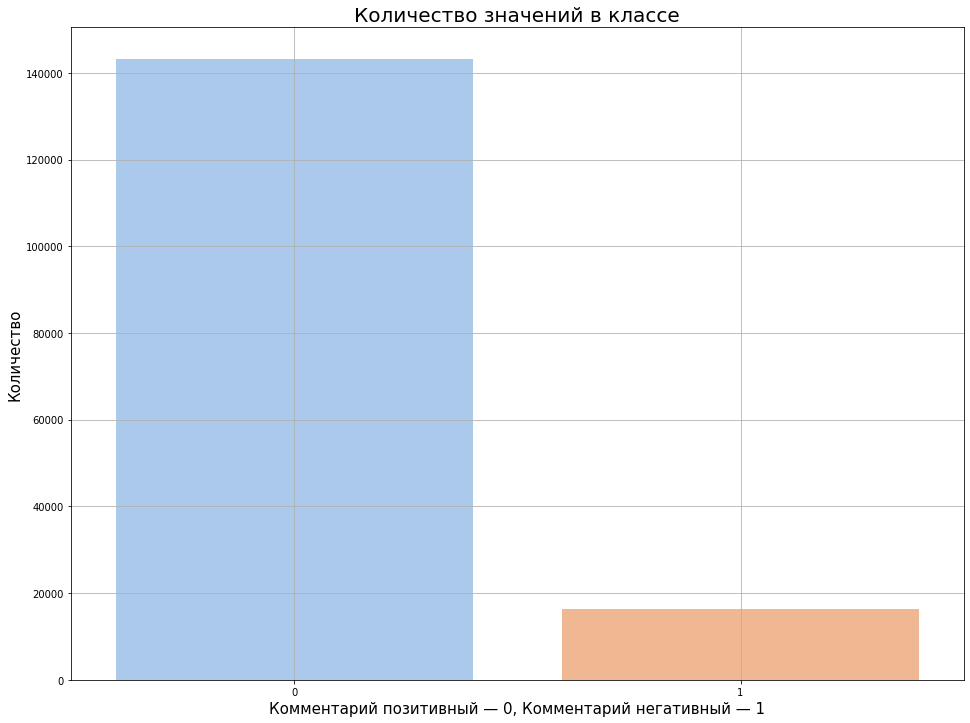

In [12]:
plt.figure(figsize=(16,12))
sns.countplot(x='toxic', data = toxic_comments, palette = "pastel")
plt.title('Количество значений в классе',fontsize=20)
plt.xlabel('Комментарий позитивный — 0, Комментарий негативный — 1', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.grid(True)
plt.show()

*Дубликатов и пропусков в данных нет, комментарии написаны  на английском языке. Присутствует дисбаланс классов*

## 1.2. Предобработка данных

In [13]:
# Приведем текст к нижнему регистру с помощью str.lower()
toxic_comments['text'] = toxic_comments['text'].str.lower()

#display(toxic_comments.head())

### Удалим ненужные символы в тексте и уберем сокращения

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [15]:
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
toxic_comments['text_v2'] = toxic_comments['text'].map(lambda com : clean_text(com))

### Лемматизация текста (Приведем все слова к их основе)

In [16]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
%%time

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    result = " ".join(lem)
    return result


toxic_comments['cleared_text_after_lemm'] = toxic_comments['text_v2'].apply(lemmatize)

CPU times: user 19min 12s, sys: 1min 2s, total: 20min 15s
Wall time: 20min 13s


In [18]:
display(toxic_comments.head())

,text,toxic,text_v2,cleared_text_after_lemm
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i am s...,d aww he match this background colour i be see...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i am really not trying to edit war it ...,hey man i be really not try to edit war it jus...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i cannot make any real suggestions on imp...,more i can not make any real suggestion on imp...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


*Лемматизировать получилось, идем дальше*

## 1.3. Преобразование данных

### TF-IDF

#### Разделим датасет на обучающую и тестовоую выборки

In [19]:
target = toxic_comments['toxic']
train, test = train_test_split(
    toxic_comments, test_size=.25, stratify=target, random_state=12345)

In [20]:
corpus_train = train['cleared_text_after_lemm'].values.astype('U')
corpus_test = test['cleared_text_after_lemm'].values.astype('U')

In [21]:
count_vect = CountVectorizer()
n_gramm_train = count_vect.fit_transform(corpus_train)

n_gramm_train.shape

(119678, 143951)

In [22]:
n_gramm_test = count_vect.transform(corpus_test)
n_gramm_test.shape

(39893, 143951)

In [23]:
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(corpus_train)

features_train.shape

(119678, 143819)

In [24]:
features_test = count_tf_idf.transform(corpus_test)
features_test.shape

(39893, 143819)

*Удалили стоп-слова. Их было не так много*

### Выделим целевой признак

In [25]:
target_train = train['toxic']
target_test = test['toxic']

## Вывод

*Общий вгляд на датасет был произведен. Дубликатов и пропусков нет, но присутствует дисбаланс данных. Данные от стоп-слов были очищены, текст был лемматищирован, также преобразовали текст с помощью метода TF-IDF*

# 2. Обучение

## 2.1. Обучение модели на обучающей выборке

### Logistic Regression

In [26]:
def lr_gridsearchcv(features, target):
    model = LogisticRegression()
    param_grid = { 
        'random_state': [42],
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'max_iter': [300, 500, 1000], 
        'class_weight' : ['balanced'],
        'C': [3, 5, 7]
    }
    CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1')
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшая F1-мера: {:.2f}'.format(CV.best_score_))
    return CV.best_params_

In [27]:
%%time
best_params_lr = lr_gridsearchcv(features_train, target_train)

Лучшие гиперпараметры:  {'C': 3, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Лучшая F1-мера: 0.76
CPU times: user 2min 13s, sys: 49.9 s, total: 3min 2s
Wall time: 2min 4s


## 2.2. Проверка модели на тестовой выборке

In [28]:
def check(model, features_train, target_train, features_test, target_test):
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    accuracy = accuracy_score(target_test, predictions)
    print('Точность модели:{:.2%}'. format(accuracy))
    print('F1-мера: {:.4f}'. format(f1_score(target_test, predictions)))
    
    
def roc(model, features_test, target_test):
    #расчитываем FPR и TPR
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    plt.figure(figsize = (10, 6))
    # ROC-кривая модели
    plt.plot(fpr, tpr, linestyle='-')
    # ROC-кривая dummy модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('ROC-кривая')
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()
    # вычисляем AUC_ROC
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    print('AUC-ROC: {:.4f}'.format(auc_roc))

Точность модели:94.80%
F1-мера: 0.7655


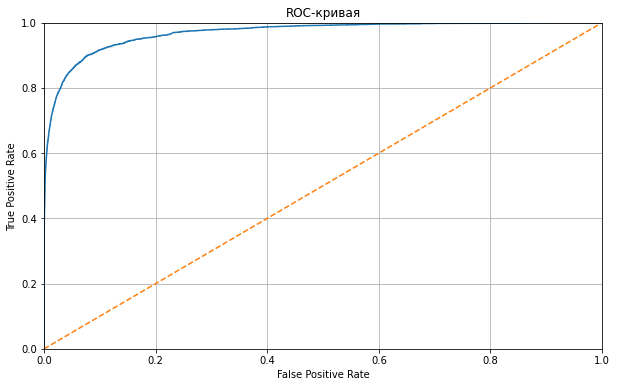

AUC-ROC: 0.9690


In [29]:
model_lr = LogisticRegression(**best_params_lr)
check(model_lr, features_train, target_train, features_test, target_test)
roc(model_lr, features_test, target_test)

*Интересно, результат на тестовой даже лучше, чем на кросс-валидации. Здесь F1 = 0.77*

## Вывод

*Обучили модель на обучающей выборке, подобрали лучшие гиперпараметры и провели тестовую проверку на тестовой выборке. Результат тестовой выборке повысился, по сравнению с обучающей. точность составила 95%*

# 3. Выводы

**Шаг 1**:
- Произвели общий вгляд на датасет. Отсутствуют пропуски и дупликаты. Присутствует дисбаланс классов
- Привели все к нижнему регистру, удалили лишние символы, провели лемматизацию и преобразовали текст с помощью метода TF-IDF

**Шаг 2**:
- Обучили несколько моделей, самые лучшие результаты метрики F1 показала логическая регрессия
- Сделали итоговую проверку модели на тестовой выборке и результаты метрики выдали хорошие значения (0.77)